In [1]:
import pickle
import numpy as np
from rul_calce_data import individual_battery_run 
from utility import cal_ttf

def rul_battery(t, y, name):
    # Calculate true TTF.
    threshold = .7*1.1
    true_ttf, idx_ttf = cal_ttf(t, y, threshold)
    t = t[:idx_ttf+10]
    y = y[:idx_ttf+10]
    T = len(t) # Number of time steps
    
    # Define the Parameters.
    # For the PF.
    sigma_u = np.array([1e-2, 1e-5, 1e-4, 1e-3])
    sigma_v = 1e-2
    Ns = 1e3
    # For the RUL prediction.
    max_ite = 60 # Maximun number of prediction states.
    max_RUL = 60 # RUL when not failure found.
    idx_start = 50
    step = 1
    idx_pred = np.arange(idx_ttf-idx_start, idx_ttf+step, step, dtype=int) # Index of the prediction instants.
    # Create the time.
    t_pred = np.arange(t[-1]+1, t[-1] + max_ite + 1, 1) 
    t_pred = np.concatenate((t, t_pred))
    
    xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, pf = individual_battery_run(t, y, sigma_u, sigma_v, Ns, threshold, idx_ttf, idx_pred, t_pred, max_ite, max_RUL)

    # Save the result.
    file_name = 'result_' + name + '.pickle'
    with open(file_name, 'wb') as f:
        pickle.dump([t, y, threshold, idx_ttf, idx_pred, true_ttf, max_RUL, 
            xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, t_pred,
            pf.particles, pf.w
        ], f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Run particle filtering to estimate the state variables.
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Directly read from the archived data.
with open('data_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

# CS2_35

In [3]:
from utility import drop_outlier_sw
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
df = data_all['CS2_38']
df1 = data_all['CS2_35']
df2 = data_all['CS2_37']


In [5]:
df1

,cycle,charging capacity,CCCT,CVCT,discharging capacity,SoH,resistance
0,1.0,1.167827,6735.323593,2312.138082,1.137444,0.822987,0.093199
1,2.0,1.145030,6613.059052,2251.498033,1.126385,0.825175,0.094009
2,3.0,1.143882,6612.402800,2231.967052,1.126160,0.815965,0.091661
3,4.0,1.142251,6608.560673,2228.216959,1.125966,0.815977,0.094649
4,5.0,1.142374,6604.732222,2247.561061,1.118508,0.825194,0.091413
...,...,...,...,...,...,...,...
931,932.0,0.315548,1036.341759,2927.592603,0.311687,0.110001,0.123073
932,933.0,0.314048,1038.404299,2918.090791,0.302522,0.110005,0.123073
933,934.0,0.312186,1015.576556,2924.668728,0.302530,0.100843,0.122374
934,935.0,0.308402,988.748763,2914.559664,0.302530,0.110014,0.123073


In [6]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


<Axes: >

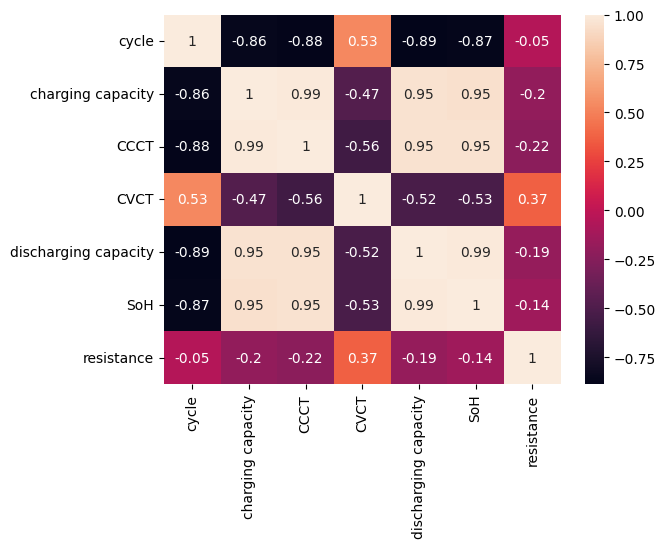

In [7]:
import seaborn as sns
sns.heatmap(df.corr(),annot=True)

In [8]:
df.fillna(method='ffill', inplace=True)
df1.fillna(method='ffill', inplace=True)
df2.fillna(method='ffill', inplace=True)

In [9]:
X = df['discharging capacity']
X1 = df1['discharging capacity']
X2 = df2['discharging capacity']


In [10]:
X

0       1.137951
1       1.126964
2       1.126642
3       1.126019
4       1.124355
          ...   
1077    0.293369
1078    0.293365
1079    0.284199
1080    0.293365
1081    0.284195
Name: discharging capacity, Length: 1082, dtype: float64

In [11]:
X1

0      1.137444
1      1.126385
2      1.126160
3      1.125966
4      1.118508
         ...   
931    0.311687
932    0.302522
933    0.302530
934    0.302530
935    0.293367
Name: discharging capacity, Length: 936, dtype: float64

In [12]:
idx = drop_outlier_sw(X,20)
idx1 = drop_outlier_sw(X1,20)
idx2 = drop_outlier_sw(X2,20)


x1 = X.iloc[idx]
x2 = X1.iloc[idx1]
x3 = X2.iloc[idx2]

In [13]:
x1

1       1.126964
2       1.126642
3       1.126019
4       1.124355
5       1.123409
          ...   
1075    0.293351
1077    0.293369
1078    0.293365
1079    0.284199
1080    0.293365
Name: discharging capacity, Length: 1031, dtype: float64

In [14]:
x2

1      1.126385
2      1.126160
3      1.125966
4      1.118508
5      1.117210
         ...   
916    0.247524
917    0.357558
918    0.357541
919    0.348375
920    0.339218
Name: discharging capacity, Length: 873, dtype: float64

X1.to_csv('X1.csv')
X2.to_csv('X2.csv')
X3.to_csv('X3.csv')

In [15]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

In [16]:
X1 = pd.DataFrame(x1)
X1 = ss.fit_transform(X1)
X1 = pd.DataFrame(X1)

X2 = pd.DataFrame(x2)
X2 = ss.fit_transform(X2)
X2 = pd.DataFrame(X2)

X3 = pd.DataFrame(x3)
X3 = ss.fit_transform(X3)
X3 = pd.DataFrame(X3)

X1 = X1[:832]
X2 = X2[:832]
X3 = X3[:832]

In [17]:
X1 = np.array(X1)
X2 = np.array(X2)
X3 = np.array(X3)

In [18]:
X1

array([[1.00000000e+00],
       [9.99618459e-01],
       [9.98878271e-01],
       ...,
       [1.08922385e-02],
       [1.63809786e-05],
       [1.08921947e-02]])

In [19]:
X1=X1.flatten()
X2=X2.flatten()
X3=X3.flatten()

In [20]:
len(X3)

989

In [21]:
X1 = pd.DataFrame(X1[:832])
X2 = pd.DataFrame(X2[:864])
X3 = pd.DataFrame(X3[:928])



In [22]:
index_x1 = np.arange(0,len(X1))
index_x2 = np.arange(0,len(X2))
index_x3 = np.arange(0,len(X3))

In [23]:
index_x1 = pd.DataFrame(index_x1)
index_x2 = pd.DataFrame(index_x2)
index_x3 = pd.DataFrame(index_x3)

In [24]:
X_1_ = pd.concat([index_x1,X1],axis=1,ignore_index=True)
X_2_ = pd.concat([index_x2,X2],axis=1,ignore_index=True)
X_3_ = pd.concat([index_x3,X3],axis=1,ignore_index=True)

In [25]:
x_1 = pd.DataFrame(X_1_)
x_2 = pd.DataFrame(X_2_)
x_3 = pd.DataFrame(X_3_)

In [26]:
x_2

,0,1
0,0,1.000000
1,1,0.999744
2,2,0.999523
3,3,0.991037
4,4,0.989561
...,...,...
859,859,0.010415
860,860,0.125155
861,861,0.125182
862,862,0.125194


In [27]:
x_2[0]

0        0
1        1
2        2
3        3
4        4
      ... 
859    859
860    860
861    861
862    862
863    863
Name: 0, Length: 864, dtype: int64

In [28]:
yyy = np.arange(0,len(X1))
yyy_1 = np.arange(0,len(X2))
yyy_2 = np.arange(0,len(X3))

In [29]:
import numpy as np
import math
from scipy.optimize import curve_fit

def my_func(x, a, b, c, d):
    return a*np.exp(b*x)+c*np.exp(d*x)

popt, pcov = curve_fit(my_func, yyy,X1[0],p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))
popt1, pcov1 = curve_fit(my_func, yyy_1,X2[0], p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))
popt2, pcov2 = curve_fit(my_func, yyy_2,X3[0], p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))



##x_hat, _ = curve_fit(degradation_mdl,xdata=t_data, ydata=y_data, p0=x0, bounds=bounds)


##x0 = np.array([1.1, -5e-5, -1.5e-3, .006])    
##bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01))



In [30]:
a,b,c,d= popt
popt

array([ 1.00000000e+00, -5.10329855e-04, -1.00000000e-03,  6.25447323e-03])

In [31]:
a1,b1,c1,d1 = popt1
popt1

array([ 1.00000000e+00, -4.99272330e-04, -1.31686706e-03,  7.17837845e-03])

In [32]:
a2,b2,c2,d2 = popt2
popt2

array([ 1.00000000e+00, -4.44382730e-04, -1.00000000e-03,  6.74705531e-03])

In [33]:
yyy_curve_fit = []

for x in yyy:
    yyy_curve_fit.append(a*np.exp(b*x)+c*np.exp(d*x))

yyy_curve_fit1 = []

for x in yyy_1:
    yyy_curve_fit1.append(a1*np.exp(b1*x)+c1*np.exp(d1*x))
    
yyy_curve_fit2 = []

for x in yyy_2:
    yyy_curve_fit2.append(a2*np.exp(b2*x)+c2*np.exp(d2*x))

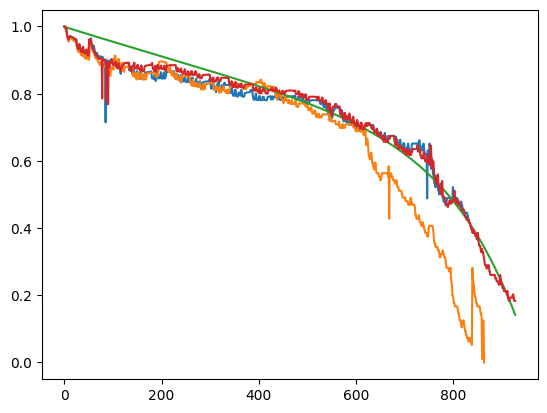

In [34]:
plt.plot(yyy,X1[0])

plt.plot(yyy_1,X2[0])

plt.plot(yyy_2,yyy_curve_fit2)
plt.plot(yyy_2,X3[0])

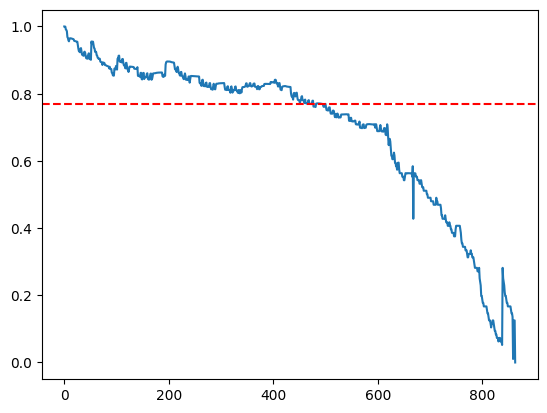

In [35]:
plt.plot(yyy_1,X2[0])
plt.axhline(y = .7*1.1, color = 'r', linestyle = '--')


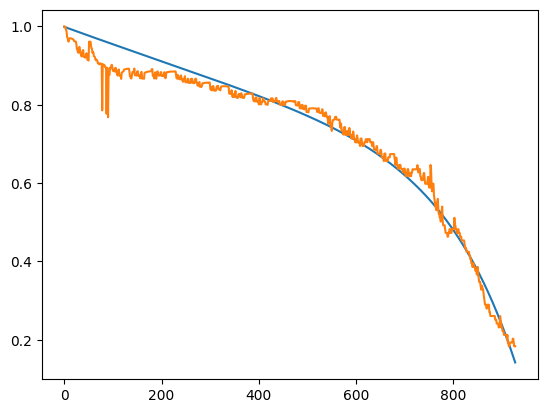

In [36]:
plt.plot(yyy_2,yyy_curve_fit2)
plt.plot(yyy_2,X3[0])

In [37]:
ax = (a+a1+a2)/3
bx = (b+b1+b2)/3
cx = (c+c1+c2)/3

In [38]:
yyy_curve_fit3 = []
for x in yyy_2:
    yyy_curve_fit3.append(a*np.exp(b*x)+c*np.exp(d*x))

[]

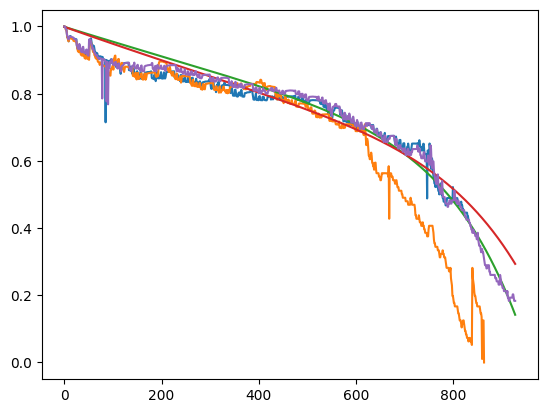

In [39]:
plt.plot(yyy,X1[0])

plt.plot(yyy_1,X2[0])

plt.plot(yyy_2,yyy_curve_fit2)

plt.plot(yyy_2,yyy_curve_fit3)

plt.plot(yyy_2,X3[0])

plt.plot()

In [40]:
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
		# find the end of this pattern
        end_ix = i + n_features
		# check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_input = 32

In [41]:
X1, y1 = prepare_data(X1[0], n_input)
X2, y2 = prepare_data(X2[0], n_input)
X3, y3 = prepare_data(X3[0], n_input)

In [42]:
X2.shape

(832, 32)

In [43]:
X1_ = X1.reshape((X1.shape[0], X1.shape[1], 1))
X2_ = X2.reshape((X2.shape[0], X2.shape[1], 1))
X3_ = X3.reshape((X3.shape[0], X3.shape[1], 1))

from keras.preprocessing.sequence import TimeseriesGenerator

df_rnn = df_rnn.reshape((len(df_rnn), 1))
generated_batches = TimeseriesGenerator(df_rnn, df_rnn, length=n_input, batch_size=1)

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.LSTM(32, activation='selu', input_shape=(n_input, 1),return_sequences=True))
model_rnn.add(keras.layers.LSTM(32, activation='selu', input_shape=(n_input, 1),return_sequences=False))
model_rnn.add(keras.layers.Dense(64, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002)))
model_rnn.add(keras.layers.Dense(32, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002)))
model_rnn.add(keras.layers.Dense(1))

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-3), loss='mse')

In [44]:
k = 0

def expo(y_true,y_pred):
    global k 
    val = y_pred - k - (a * np.exp(b) + c )
    k = y_pred
    print(val + tf.math.abs(y_true-y_pred))
    print(tf.executing_eagerly())
    return val + tf.math.abs(y_true-y_pred)

    

        

In [45]:
def function(x):
    return (a*(x**2) + b*(x)+ c)

In [46]:
def huber_fn(y_true, y_pred):

    error = y_true - y_pred
    is_small_error = tensorflow.abs(error) < 1
    squared_loss = tensorflow.square(error) / 2 
    linear_loss  = tensorflow.abs(error) - 0.5
    print(y_pred.shape)
    print(tf.executing_eagerly())
    return tf.where(is_small_error, squared_loss, linear_loss)

a = (a+a1+a2)/3
b = (b+b1+b2)/3
c = (c+c1+c2)/3

In [47]:
x_1[1][2]

0.9988782708035651

In [48]:
1 in x_1.values

True

In [49]:
from sklearn.metrics import mean_squared_error

cycle_arr = []
theoretical = []

def custom(y_true,y_pred):
    global cycle_arr
    global x_1
    for i in y_true:
        if i in x_1.values:
            cycle_arr.append(x_1[x_1[1]==i][0].iloc[0])
        if i in x_2.values:
            cycle_arr.append(x_2[x_2[1]==i][0].iloc[0])
        if i in x_3.values:
            cycle_arr.append(x_3[x_3[1]==i][0].iloc[0])
    
    if y_true[0] in x_1.values: 
        for cycle in cycle_arr:
            theoretical.append([a*np.exp(b*(cycle))+c*np.exp(d*(cycle))])
        mae = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + mae
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x1')
        return error

    if y_true[0] in x_2.values:
        for cycle in cycle_arr:
            theoretical.append([a1*np.exp(b1*(cycle))+c1*np.exp(d1*(cycle))])
        mae = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + mae
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x2')
        return error

    if y_true[0] in x_3.values:
        for cycle in cycle_arr:
            theoretical.append([a2*np.exp(b2*(cycle))+c2*np.exp(d2*(cycle))])
        mae = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + mae
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x3')
        return error


In [50]:
x_2

,0,1
0,0,1.000000
1,1,0.999744
2,2,0.999523
3,3,0.991037
4,4,0.989561
...,...,...
859,859,0.010415
860,860,0.125155
861,861,0.125182
862,862,0.125194


cycle_arr1 = []
theoretical1 = []

def custom1(y_true,y_pred):
    global cycle_arr1
    global x_1
    for i in y_true:
        cycle_arr1.append(x_3[x_3[1]==i][0].iloc[0])
    for cycle in cycle_arr1:
        theoretical1.append([a1*(cycle)**2+b1*(cycle)+c1])
    rmse = tf.math.abs(y_true-y_pred)
    diff = tf.math.abs((y_pred) - np.array(theoretical1))
    error = diff + rmse
    print(tf.executing_eagerly())
    cycle_arr1.clear()
    theoretical1.clear()
    return error
    

cycle_arr2 = []
theoretical2 = []

def custom2(y_true,y_pred):
    global cycle_arr2
    global x_1
    for i in y_true:
        cycle_arr2.append(x_1[x_1[1]==i][0].iloc[0])
    for cycle in cycle_arr2:
        theoretical2.append([a2*(cycle)**2+b2*(cycle)+c2])
    rmse = tf.math.abs(y_true-y_pred)
    diff = tf.math.abs((y_pred) - np.array(theoretical2))
    error = diff + rmse
    print(tf.executing_eagerly())
    cycle_arr2.clear()
    theoretical2.clear()
    return error
    

In [51]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM


from numpy.random import seed
seed(42)



model_rnn = Sequential()
model_rnn.add(LSTM(64,
                return_sequences=False))

model_rnn.add(Dense(16, activation='relu'))

model_rnn.add(Dense(1, activation='linear'))

model_rnn.compile(optimizer='adam', loss=custom, metrics=['mse', 'mae', 'mape'],run_eagerly = True)

Metal device set to: Apple M1


In [52]:
model_rnn.fit(X1_,y1, epochs=30, verbose=1)

Epoch 1/30


2023-07-20 14:10:05.969260: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


True
x1
 1/25 [>.............................] - ETA: 19s - loss: 1.6439 - mse: 0.6718 - mae: 0.8112 - mape: 104.0283True
x1
 2/25 [=>............................] - ETA: 3s - loss: 1.5743 - mse: 0.6235 - mae: 0.7783 - mape: 102.2969 True
x1
 3/25 [==>...........................] - ETA: 3s - loss: 1.5345 - mse: 0.5957 - mae: 0.7604 - mape: 100.7418True
x1
 4/25 [===>..........................] - ETA: 3s - loss: 1.5075 - mse: 0.5764 - mae: 0.7468 - mape: 99.2477 True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 1.4925 - mse: 0.5640 - mae: 0.7402 - mape: 97.8755True
x1
 6/25 [======>.......................] - ETA: 2s - loss: 1.4696 - mse: 0.5481 - mae: 0.7295 - mape: 96.6069True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 1.4489 - mse: 0.5334 - mae: 0.7193 - mape: 95.3882True
x1
 8/25 [========>.....................] - ETA: 3s - loss: 1.4298 - mse: 0.5200 - mae: 0.7099 - mape: 94.1835True
x1
 9/25 [=========>....................] - ETA: 2s - loss: 1.4088 - 

22/25 [=========================>....] - ETA: 0s - loss: 0.1288 - mse: 0.0048 - mae: 0.0536 - mape: 7.8604True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.1269 - mse: 0.0046 - mae: 0.0525 - mape: 7.6765True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.1250 - mse: 0.0045 - mae: 0.0517 - mape: 7.5533True
x1
25/25 [==============================] - 5s 200ms/step - loss: 0.1234 - mse: 0.0044 - mae: 0.0512 - mape: 7.4629
Epoch 4/30
True
x1
 1/25 [>.............................] - ETA: 4s - loss: 0.0681 - mse: 9.3264e-04 - mae: 0.0255 - mape: 3.5933True
x1
 2/25 [=>............................] - ETA: 4s - loss: 0.0720 - mse: 0.0010 - mae: 0.0256 - mape: 3.8246    True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 0.0799 - mse: 0.0016 - mae: 0.0325 - mape: 4.8592True
x1
 4/25 [===>..........................] - ETA: 4s - loss: 0.0779 - mse: 0.0015 - mae: 0.0314 - mape: 4.7023True
x1
 5/25 [=====>........................] - ETA: 4s - loss: 0.072

17/25 [===================>..........] - ETA: 1s - loss: 0.0479 - mse: 4.5703e-04 - mae: 0.0161 - mape: 2.1884True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0475 - mse: 4.4101e-04 - mae: 0.0158 - mape: 2.1494True
x1
19/25 [=====================>........] - ETA: 1s - loss: 0.0480 - mse: 4.6772e-04 - mae: 0.0160 - mape: 2.2078True
x1
20/25 [=======================>......] - ETA: 0s - loss: 0.0474 - mse: 4.5340e-04 - mae: 0.0158 - mape: 2.1787True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0469 - mse: 4.4403e-04 - mae: 0.0157 - mape: 2.1670True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0469 - mse: 4.5345e-04 - mae: 0.0160 - mape: 2.2039True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0464 - mse: 4.4323e-04 - mae: 0.0158 - mape: 2.1787True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0469 - mse: 4.4610e-04 - mae: 0.0160 - mape: 2.2011True
x1
25/25 [==============================] - 5s 197ms/step -

11/25 [============>.................] - ETA: 2s - loss: 0.0389 - mse: 4.3377e-04 - mae: 0.0133 - mape: 1.8031True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0391 - mse: 4.2850e-04 - mae: 0.0135 - mape: 1.8182True
x1
13/25 [==============>...............] - ETA: 2s - loss: 0.0390 - mse: 4.1527e-04 - mae: 0.0134 - mape: 1.8127True
x1
14/25 [===============>..............] - ETA: 2s - loss: 0.0389 - mse: 4.0578e-04 - mae: 0.0134 - mape: 1.8168True
x1
15/25 [=================>............] - ETA: 1s - loss: 0.0392 - mse: 4.0755e-04 - mae: 0.0136 - mape: 1.8517True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0393 - mse: 4.1324e-04 - mae: 0.0140 - mape: 1.8871True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0389 - mse: 3.9881e-04 - mae: 0.0138 - mape: 1.8630True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0393 - mse: 4.0099e-04 - mae: 0.0139 - mape: 1.8918True
x1
19/25 [=====================>........] - ETA: 1s - loss:

 5/25 [=====>........................] - ETA: 3s - loss: 0.0390 - mse: 3.6153e-04 - mae: 0.0133 - mape: 1.8657True
x1
 6/25 [======>.......................] - ETA: 2s - loss: 0.0379 - mse: 3.2335e-04 - mae: 0.0127 - mape: 1.7646True
x1
 7/25 [=======>......................] - ETA: 2s - loss: 0.0382 - mse: 3.5826e-04 - mae: 0.0137 - mape: 1.8673True
x1
 8/25 [========>.....................] - ETA: 2s - loss: 0.0390 - mse: 3.8276e-04 - mae: 0.0143 - mape: 1.9376True
x1
 9/25 [=========>....................] - ETA: 2s - loss: 0.0387 - mse: 3.6402e-04 - mae: 0.0141 - mape: 1.8868True
x1
10/25 [===========>..................] - ETA: 2s - loss: 0.0397 - mse: 4.9051e-04 - mae: 0.0148 - mape: 2.0074True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0396 - mse: 4.6508e-04 - mae: 0.0145 - mape: 1.9609True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0392 - mse: 4.5012e-04 - mae: 0.0144 - mape: 1.9419True
x1
13/25 [==============>...............] - ETA: 1s - loss:

24/25 [===========================>..] - ETA: 0s - loss: 0.0391 - mse: 3.9254e-04 - mae: 0.0144 - mape: 1.9422True
x1
25/25 [==============================] - 4s 154ms/step - loss: 0.0391 - mse: 3.9657e-04 - mae: 0.0145 - mape: 1.9528
Epoch 15/30
True
x1
 1/25 [>.............................] - ETA: 3s - loss: 0.0406 - mse: 3.5071e-04 - mae: 0.0143 - mape: 1.8007True
x1
 2/25 [=>............................] - ETA: 3s - loss: 0.0371 - mse: 2.9071e-04 - mae: 0.0132 - mape: 1.7563True
x1
 3/25 [==>...........................] - ETA: 3s - loss: 0.0404 - mse: 7.4211e-04 - mae: 0.0156 - mape: 2.1290True
x1
 4/25 [===>..........................] - ETA: 3s - loss: 0.0401 - mse: 6.6877e-04 - mae: 0.0158 - mape: 2.1142True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 0.0389 - mse: 6.0624e-04 - mae: 0.0156 - mape: 2.1041True
x1
 6/25 [======>.......................] - ETA: 2s - loss: 0.0384 - mse: 5.4884e-04 - mae: 0.0152 - mape: 2.0448True
x1
 7/25 [=======>......................

18/25 [====================>.........] - ETA: 1s - loss: 0.0362 - mse: 3.2333e-04 - mae: 0.0133 - mape: 1.8057True
x1
19/25 [=====================>........] - ETA: 0s - loss: 0.0364 - mse: 3.2013e-04 - mae: 0.0132 - mape: 1.7984True
x1
20/25 [=======================>......] - ETA: 0s - loss: 0.0366 - mse: 3.2632e-04 - mae: 0.0134 - mape: 1.8126True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0366 - mse: 3.1879e-04 - mae: 0.0133 - mape: 1.7951True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0367 - mse: 3.1433e-04 - mae: 0.0132 - mape: 1.7840True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0368 - mse: 3.9315e-04 - mae: 0.0137 - mape: 1.8367True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0368 - mse: 3.9848e-04 - mae: 0.0138 - mape: 1.8489True
x1
25/25 [==============================] - 4s 155ms/step - loss: 0.0370 - mse: 3.9411e-04 - mae: 0.0138 - mape: 1.8528
Epoch 18/30
True
x1
 1/25 [>.............................

12/25 [=============>................] - ETA: 2s - loss: 0.0402 - mse: 5.1366e-04 - mae: 0.0165 - mape: 2.1680True
x1
13/25 [==============>...............] - ETA: 2s - loss: 0.0397 - mse: 4.8439e-04 - mae: 0.0159 - mape: 2.0893True
x1
14/25 [===============>..............] - ETA: 2s - loss: 0.0397 - mse: 4.8526e-04 - mae: 0.0160 - mape: 2.1119True
x1
15/25 [=================>............] - ETA: 2s - loss: 0.0394 - mse: 4.6626e-04 - mae: 0.0157 - mape: 2.0822True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0395 - mse: 4.5255e-04 - mae: 0.0155 - mape: 2.0565True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0393 - mse: 4.3818e-04 - mae: 0.0153 - mape: 2.0261True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0396 - mse: 4.7539e-04 - mae: 0.0156 - mape: 2.0848True
x1
19/25 [=====================>........] - ETA: 1s - loss: 0.0395 - mse: 4.6910e-04 - mae: 0.0156 - mape: 2.0847True
x1
20/25 [=======================>......] - ETA: 1s - loss:

 6/25 [======>.......................] - ETA: 4s - loss: 0.0413 - mse: 5.2781e-04 - mae: 0.0180 - mape: 2.3429True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 0.0410 - mse: 4.7861e-04 - mae: 0.0169 - mape: 2.2293True
x1
 8/25 [========>.....................] - ETA: 3s - loss: 0.0407 - mse: 4.6373e-04 - mae: 0.0169 - mape: 2.2232True
x1
 9/25 [=========>....................] - ETA: 3s - loss: 0.0405 - mse: 4.4639e-04 - mae: 0.0166 - mape: 2.1864True
x1
10/25 [===========>..................] - ETA: 3s - loss: 0.0401 - mse: 4.6484e-04 - mae: 0.0169 - mape: 2.2050True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0396 - mse: 4.4182e-04 - mae: 0.0163 - mape: 2.1465True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0397 - mse: 4.2340e-04 - mae: 0.0160 - mape: 2.1173True
x1
13/25 [==============>...............] - ETA: 2s - loss: 0.0397 - mse: 4.0549e-04 - mae: 0.0157 - mape: 2.0695True
x1
14/25 [===============>..............] - ETA: 2s - loss:

25/25 [==============================] - 5s 218ms/step - loss: 0.0390 - mse: 4.8419e-04 - mae: 0.0160 - mape: 2.1221
Epoch 26/30
True
x1
 1/25 [>.............................] - ETA: 5s - loss: 0.0468 - mse: 4.9329e-04 - mae: 0.0185 - mape: 2.7178True
x1
 2/25 [=>............................] - ETA: 4s - loss: 0.0428 - mse: 4.0325e-04 - mae: 0.0166 - mape: 2.3836True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 0.0429 - mse: 4.1147e-04 - mae: 0.0162 - mape: 2.2222True
x1
 4/25 [===>..........................] - ETA: 4s - loss: 0.0415 - mse: 3.7383e-04 - mae: 0.0158 - mape: 2.1281True
x1
 5/25 [=====>........................] - ETA: 4s - loss: 0.0391 - mse: 3.2638e-04 - mae: 0.0145 - mape: 1.9710True
x1
 6/25 [======>.......................] - ETA: 4s - loss: 0.0388 - mse: 3.0613e-04 - mae: 0.0140 - mape: 1.9246True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 0.0380 - mse: 2.9822e-04 - mae: 0.0136 - mape: 1.8505True
x1
 8/25 [========>.....................

19/25 [=====================>........] - ETA: 1s - loss: 0.0422 - mse: 5.8345e-04 - mae: 0.0189 - mape: 2.4736True
x1
20/25 [=======================>......] - ETA: 1s - loss: 0.0419 - mse: 5.6629e-04 - mae: 0.0185 - mape: 2.4341True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0423 - mse: 6.0994e-04 - mae: 0.0186 - mape: 2.4581True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0419 - mse: 5.9042e-04 - mae: 0.0183 - mape: 2.4189True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0422 - mse: 6.1253e-04 - mae: 0.0186 - mape: 2.4614True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0423 - mse: 6.0770e-04 - mae: 0.0186 - mape: 2.4557True
x1
25/25 [==============================] - 5s 216ms/step - loss: 0.0422 - mse: 5.9444e-04 - mae: 0.0184 - mape: 2.4289
Epoch 29/30
True
x1
 1/25 [>.............................] - ETA: 5s - loss: 0.0389 - mse: 2.0926e-04 - mae: 0.0119 - mape: 1.7239True
x1
 2/25 [=>............................

In [53]:
model_rnn.fit(X2_,y2, epochs=30, verbose=1)

Epoch 1/30
True
x2
 1/26 [>.............................] - ETA: 5s - loss: 0.0458 - mse: 0.0015 - mae: 0.0262 - mape: 14.3492True
x2
 2/26 [=>............................] - ETA: 5s - loss: 0.0442 - mse: 9.7968e-04 - mae: 0.0202 - mape: 10.3790True
x2
 3/26 [==>...........................] - ETA: 4s - loss: 0.0465 - mse: 9.2340e-04 - mae: 0.0216 - mape: 8.8007 True
x2
 4/26 [===>..........................] - ETA: 4s - loss: 0.0477 - mse: 9.2475e-04 - mae: 0.0217 - mape: 8.3435True
x2
 5/26 [====>.........................] - ETA: 4s - loss: 0.0477 - mse: 9.2117e-04 - mae: 0.0218 - mape: 8.3552True
x2
 6/26 [=====>........................] - ETA: 4s - loss: 0.0484 - mse: 9.9601e-04 - mae: 0.0232 - mape: 8.0312True
x2
 7/26 [=======>......................] - ETA: 4s - loss: 0.0488 - mse: 9.8497e-04 - mae: 0.0231 - mape: 7.7853True
x2
 8/26 [========>.....................] - ETA: 3s - loss: 0.0491 - mse: 9.9215e-04 - mae: 0.0225 - mape: 7.2615True
x2
 9/26 [=========>....................]

16/26 [=================>............] - ETA: 2s - loss: 0.0445 - mse: 5.9501e-04 - mae: 0.0173 - mape: 2866.3013True
x2
17/26 [==================>...........] - ETA: 2s - loss: 0.0450 - mse: 6.3983e-04 - mae: 0.0175 - mape: 2701.1846True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0450 - mse: 6.2843e-04 - mae: 0.0173 - mape: 2551.4036True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0450 - mse: 6.2012e-04 - mae: 0.0172 - mape: 2417.2671True
x2
20/26 [======================>.......] - ETA: 1s - loss: 0.0447 - mse: 6.0884e-04 - mae: 0.0171 - mape: 2296.5369True
x2
21/26 [=======================>......] - ETA: 1s - loss: 0.0443 - mse: 5.9368e-04 - mae: 0.0169 - mape: 2187.2625True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0446 - mse: 6.2382e-04 - mae: 0.0170 - mape: 2088.0747True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0445 - mse: 6.2241e-04 - mae: 0.0170 - mape: 1997.6050True
x2
24/26 [=========================

 6/26 [=====>........................] - ETA: 4s - loss: 0.0459 - mse: 6.6890e-04 - mae: 0.0181 - mape: 14.7442True
x2
 7/26 [=======>......................] - ETA: 3s - loss: 0.0455 - mse: 6.3075e-04 - mae: 0.0178 - mape: 13.0708True
x2
 8/26 [========>.....................] - ETA: 3s - loss: 0.0452 - mse: 6.0076e-04 - mae: 0.0173 - mape: 12.0211True
x2
 9/26 [=========>....................] - ETA: 3s - loss: 0.0455 - mse: 6.1055e-04 - mae: 0.0178 - mape: 11.4612True
x2
10/26 [==========>...................] - ETA: 3s - loss: 0.0450 - mse: 6.1866e-04 - mae: 0.0182 - mape: 10.7439True
x2
11/26 [===========>..................] - ETA: 3s - loss: 0.0449 - mse: 6.3717e-04 - mae: 0.0182 - mape: 10.2006True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0455 - mse: 6.1525e-04 - mae: 0.0178 - mape: 9.5649 True
x2
13/26 [==============>...............] - ETA: 2s - loss: 0.0451 - mse: 5.8857e-04 - mae: 0.0174 - mape: 8.9666True
x2
14/26 [===============>..............] - ETA: 2s 

22/26 [========================>.....] - ETA: 0s - loss: 0.0441 - mse: 5.6991e-04 - mae: 0.0167 - mape: 7.2425True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0440 - mse: 5.6983e-04 - mae: 0.0166 - mape: 7.2163True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0438 - mse: 5.6714e-04 - mae: 0.0166 - mape: 7.0033True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0439 - mse: 5.7249e-04 - mae: 0.0168 - mape: 7.0249True
x2
26/26 [==============================] - 4s 163ms/step - loss: 0.0442 - mse: 5.9398e-04 - mae: 0.0169 - mape: 1724.0875
Epoch 9/30
True
x2
 1/26 [>.............................] - ETA: 3s - loss: 0.0409 - mse: 3.4802e-04 - mae: 0.0146 - mape: 5.9037True
x2
 2/26 [=>............................] - ETA: 3s - loss: 0.0447 - mse: 4.3805e-04 - mae: 0.0164 - mape: 6.1547True
x2
 3/26 [==>...........................] - ETA: 4s - loss: 0.0430 - mse: 4.0429e-04 - mae: 0.0154 - mape: 4.9474True
x2
 4/26 [===>........................

12/26 [============>.................] - ETA: 2s - loss: 0.0460 - mse: 5.8647e-04 - mae: 0.0177 - mape: 5.6009True
x2
13/26 [==============>...............] - ETA: 2s - loss: 0.0456 - mse: 5.9144e-04 - mae: 0.0178 - mape: 5.4145True
x2
14/26 [===============>..............] - ETA: 2s - loss: 0.0456 - mse: 6.0635e-04 - mae: 0.0181 - mape: 5.4682True
x2
15/26 [================>.............] - ETA: 2s - loss: 0.0454 - mse: 5.9485e-04 - mae: 0.0180 - mape: 5.2735True
x2
16/26 [=================>............] - ETA: 1s - loss: 0.0450 - mse: 5.8245e-04 - mae: 0.0177 - mape: 5.3797True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0445 - mse: 5.5959e-04 - mae: 0.0173 - mape: 5.1539True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0439 - mse: 5.3750e-04 - mae: 0.0169 - mape: 4.9408True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0434 - mse: 5.2237e-04 - mae: 0.0166 - mape: 4.8197True
x2
20/26 [======================>.......] - ETA: 1s - loss:

 2/26 [=>............................] - ETA: 4s - loss: 0.0492 - mse: 7.5605e-04 - mae: 0.0182 - mape: 20229.5273True
x2
 3/26 [==>...........................] - ETA: 4s - loss: 0.0527 - mse: 0.0012 - mae: 0.0204 - mape: 13504.7031    True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0517 - mse: 0.0010 - mae: 0.0197 - mape: 10129.8613True
x2
 5/26 [====>.........................] - ETA: 3s - loss: 0.0501 - mse: 9.8544e-04 - mae: 0.0203 - mape: 8105.9097True
x2
 6/26 [=====>........................] - ETA: 3s - loss: 0.0489 - mse: 8.8340e-04 - mae: 0.0194 - mape: 6755.4248True
x2
 7/26 [=======>......................] - ETA: 3s - loss: 0.0478 - mse: 7.9092e-04 - mae: 0.0184 - mape: 5790.6968True
x2
 8/26 [========>.....................] - ETA: 3s - loss: 0.0484 - mse: 7.7188e-04 - mae: 0.0188 - mape: 5067.5923True
x2
 9/26 [=========>....................] - ETA: 3s - loss: 0.0485 - mse: 7.2214e-04 - mae: 0.0183 - mape: 4504.9556True
x2
10/26 [==========>...............

17/26 [==================>...........] - ETA: 1s - loss: 0.0425 - mse: 5.5483e-04 - mae: 0.0164 - mape: 2371.9670True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0427 - mse: 5.5826e-04 - mae: 0.0164 - mape: 2240.3918True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0427 - mse: 5.5042e-04 - mae: 0.0164 - mape: 2122.6152True
x2
20/26 [======================>.......] - ETA: 0s - loss: 0.0429 - mse: 5.5475e-04 - mae: 0.0165 - mape: 2017.0537True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0434 - mse: 5.8689e-04 - mae: 0.0167 - mape: 1923.5261True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0434 - mse: 5.7809e-04 - mae: 0.0167 - mape: 1836.3246True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0435 - mse: 5.7345e-04 - mae: 0.0166 - mape: 1756.6318True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0434 - mse: 5.6772e-04 - mae: 0.0166 - mape: 1683.5691True
x2
25/26 [=========================

 6/26 [=====>........................] - ETA: 3s - loss: 0.0458 - mse: 6.4466e-04 - mae: 0.0189 - mape: 4.8495True
x2
 7/26 [=======>......................] - ETA: 2s - loss: 0.0460 - mse: 6.3441e-04 - mae: 0.0189 - mape: 4.6671True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0450 - mse: 5.9683e-04 - mae: 0.0182 - mape: 4.4937True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0445 - mse: 5.8097e-04 - mae: 0.0181 - mape: 4.5875True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0437 - mse: 5.4955e-04 - mae: 0.0175 - mape: 4.4778True
x2
11/26 [===========>..................] - ETA: 2s - loss: 0.0448 - mse: 6.3603e-04 - mae: 0.0180 - mape: 4.7917True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0443 - mse: 6.0477e-04 - mae: 0.0176 - mape: 4.5611True
x2
13/26 [==============>...............] - ETA: 1s - loss: 0.0448 - mse: 6.0399e-04 - mae: 0.0177 - mape: 4.7643True
x2
14/26 [===============>..............] - ETA: 1s - loss:

22/26 [========================>.....] - ETA: 0s - loss: 0.0453 - mse: 6.1877e-04 - mae: 0.0177 - mape: 1844.6226True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0451 - mse: 6.0799e-04 - mae: 0.0175 - mape: 1764.6437True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0450 - mse: 6.0509e-04 - mae: 0.0176 - mape: 1691.2937True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0449 - mse: 6.0138e-04 - mae: 0.0176 - mape: 1623.8922True
x2
26/26 [==============================] - 5s 203ms/step - loss: 0.0450 - mse: 5.9910e-04 - mae: 0.0176 - mape: 1561.7738
Epoch 22/30
True
x2
 1/26 [>.............................] - ETA: 5s - loss: 0.0495 - mse: 0.0012 - mae: 0.0210 - mape: 53.6418True
x2
 2/26 [=>............................] - ETA: 4s - loss: 0.0434 - mse: 7.5435e-04 - mae: 0.0174 - mape: 28.5387True
x2
 3/26 [==>...........................] - ETA: 4s - loss: 0.0444 - mse: 6.1959e-04 - mae: 0.0166 - mape: 20.1162True
x2
 4/26 [===>............

12/26 [============>.................] - ETA: 1s - loss: 0.0432 - mse: 5.3797e-04 - mae: 0.0161 - mape: 4.0306True
x2
13/26 [==============>...............] - ETA: 1s - loss: 0.0442 - mse: 5.8715e-04 - mae: 0.0165 - mape: 7.8547True
x2
14/26 [===============>..............] - ETA: 1s - loss: 0.0447 - mse: 5.8208e-04 - mae: 0.0167 - mape: 7.7416True
x2
15/26 [================>.............] - ETA: 1s - loss: 0.0445 - mse: 5.6041e-04 - mae: 0.0166 - mape: 7.3654True
x2
16/26 [=================>............] - ETA: 1s - loss: 0.0444 - mse: 5.4529e-04 - mae: 0.0164 - mape: 7.0578True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0445 - mse: 5.6012e-04 - mae: 0.0168 - mape: 7.1342True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0448 - mse: 5.7030e-04 - mae: 0.0169 - mape: 7.0099True
x2
19/26 [====================>.........] - ETA: 0s - loss: 0.0446 - mse: 5.5435e-04 - mae: 0.0167 - mape: 6.7689True
x2
20/26 [======================>.......] - ETA: 0s - loss:

 2/26 [=>............................] - ETA: 3s - loss: 0.0495 - mse: 5.8747e-04 - mae: 0.0194 - mape: 3.5082True
x2
 3/26 [==>...........................] - ETA: 3s - loss: 0.0508 - mse: 6.9035e-04 - mae: 0.0221 - mape: 3.5809True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0500 - mse: 6.2295e-04 - mae: 0.0210 - mape: 3.4457True
x2
 5/26 [====>.........................] - ETA: 2s - loss: 0.0502 - mse: 7.4096e-04 - mae: 0.0228 - mape: 4.0981True
x2
 6/26 [=====>........................] - ETA: 2s - loss: 0.0511 - mse: 8.0944e-04 - mae: 0.0241 - mape: 4.1672True
x2
 7/26 [=======>......................] - ETA: 2s - loss: 0.0516 - mse: 8.5312e-04 - mae: 0.0237 - mape: 5950.5698True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0536 - mse: 9.6180e-04 - mae: 0.0243 - mape: 5207.8057True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0539 - mse: 9.4317e-04 - mae: 0.0242 - mape: 4629.9072True
x2
10/26 [==========>...................] - ETA: 2

18/26 [===================>..........] - ETA: 1s - loss: 0.0431 - mse: 5.7281e-04 - mae: 0.0162 - mape: 2194.2144True
x2
19/26 [====================>.........] - ETA: 0s - loss: 0.0432 - mse: 5.8655e-04 - mae: 0.0163 - mape: 2079.0708True
x2
20/26 [======================>.......] - ETA: 0s - loss: 0.0429 - mse: 5.7199e-04 - mae: 0.0161 - mape: 1975.2725True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0428 - mse: 5.6189e-04 - mae: 0.0160 - mape: 1881.4125True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0426 - mse: 5.5176e-04 - mae: 0.0159 - mape: 1795.9998True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0426 - mse: 5.4683e-04 - mae: 0.0159 - mape: 1718.1624True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0429 - mse: 5.4097e-04 - mae: 0.0160 - mape: 1646.7894True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0430 - mse: 5.3374e-04 - mae: 0.0160 - mape: 1581.0676True
x2
26/26 [=========================

In [54]:
model_rnn.fit(X3_,y3, epochs=30, verbose=1)

Epoch 1/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0305 - mse: 3.6285e-04 - mae: 0.0144 - mape: 2.4544True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0334 - mse: 5.4973e-04 - mae: 0.0173 - mape: 2.8355True
x3
 3/28 [==>...........................] - ETA: 3s - loss: 0.0330 - mse: 4.3195e-04 - mae: 0.0154 - mape: 2.5244True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0326 - mse: 3.7040e-04 - mae: 0.0144 - mape: 2.3247True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0342 - mse: 3.8888e-04 - mae: 0.0153 - mape: 2.5983True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0342 - mse: 3.9529e-04 - mae: 0.0157 - mape: 2.6608True
x3
 7/28 [======>.......................] - ETA: 3s - loss: 0.0339 - mse: 3.7128e-04 - mae: 0.0153 - mape: 2.5891True
x3
 8/28 [=======>......................] - ETA: 2s - loss: 0.0345 - mse: 3.6683e-04 - mae: 0.0154 - mape: 2.5590True
x3
 9/28 [========>.....................

14/28 [==============>...............] - ETA: 2s - loss: 0.0336 - mse: 3.6599e-04 - mae: 0.0146 - mape: 2.0769True
x3
15/28 [===============>..............] - ETA: 1s - loss: 0.0347 - mse: 3.7194e-04 - mae: 0.0149 - mape: 2.1343True
x3
16/28 [================>.............] - ETA: 1s - loss: 0.0343 - mse: 3.5707e-04 - mae: 0.0145 - mape: 2.1041True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0351 - mse: 3.8608e-04 - mae: 0.0152 - mape: 2.1886True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0354 - mse: 3.9625e-04 - mae: 0.0155 - mape: 2.2321True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0356 - mse: 3.9067e-04 - mae: 0.0154 - mape: 2.2276True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0360 - mse: 3.9318e-04 - mae: 0.0156 - mape: 2.2514True
x3
21/28 [=====================>........] - ETA: 1s - loss: 0.0356 - mse: 3.8286e-04 - mae: 0.0153 - mape: 2.2210True
x3
22/28 [======================>.......] - ETA: 0s - loss:

27/28 [===========================>..] - ETA: 0s - loss: 0.0310 - mse: 3.5659e-04 - mae: 0.0134 - mape: 1.9524True
x3
28/28 [==============================] - 4s 144ms/step - loss: 0.0310 - mse: 3.5423e-04 - mae: 0.0135 - mape: 1.9574
Epoch 6/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0345 - mse: 2.6862e-04 - mae: 0.0139 - mape: 2.3024True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0334 - mse: 2.5612e-04 - mae: 0.0133 - mape: 2.1577True
x3
 3/28 [==>...........................] - ETA: 3s - loss: 0.0327 - mse: 2.9595e-04 - mae: 0.0136 - mape: 2.1053True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0331 - mse: 3.1747e-04 - mae: 0.0141 - mape: 2.1108True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0315 - mse: 2.8655e-04 - mae: 0.0133 - mape: 1.9847True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0324 - mse: 2.7201e-04 - mae: 0.0131 - mape: 1.9285True
x3
 7/28 [======>.......................]

12/28 [===========>..................] - ETA: 2s - loss: 0.0332 - mse: 3.8675e-04 - mae: 0.0141 - mape: 2.0297True
x3
13/28 [============>.................] - ETA: 2s - loss: 0.0324 - mse: 3.7039e-04 - mae: 0.0138 - mape: 1.9861True
x3
14/28 [==============>...............] - ETA: 2s - loss: 0.0328 - mse: 4.3698e-04 - mae: 0.0145 - mape: 2.0602True
x3
15/28 [===============>..............] - ETA: 1s - loss: 0.0328 - mse: 4.4248e-04 - mae: 0.0147 - mape: 2.0842True
x3
16/28 [================>.............] - ETA: 1s - loss: 0.0325 - mse: 4.2586e-04 - mae: 0.0144 - mape: 2.0486True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0326 - mse: 4.1307e-04 - mae: 0.0142 - mape: 2.0544True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0327 - mse: 4.2175e-04 - mae: 0.0145 - mape: 2.0857True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0327 - mse: 4.1743e-04 - mae: 0.0144 - mape: 2.0809True
x3
20/28 [====================>.........] - ETA: 1s - loss:

25/28 [=========================>....] - ETA: 0s - loss: 0.0297 - mse: 2.6855e-04 - mae: 0.0122 - mape: 1.7940True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0300 - mse: 3.0696e-04 - mae: 0.0126 - mape: 1.8408True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0299 - mse: 3.0104e-04 - mae: 0.0125 - mape: 1.8399True
x3
28/28 [==============================] - 4s 145ms/step - loss: 0.0306 - mse: 3.1728e-04 - mae: 0.0127 - mape: 1.8757
Epoch 11/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0312 - mse: 2.0223e-04 - mae: 0.0109 - mape: 1.5609True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0289 - mse: 2.5496e-04 - mae: 0.0127 - mape: 1.7055True
x3
 3/28 [==>...........................] - ETA: 3s - loss: 0.0297 - mse: 2.5630e-04 - mae: 0.0126 - mape: 1.8472True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0292 - mse: 2.4216e-04 - mae: 0.0120 - mape: 1.7461True
x3
 5/28 [====>.........................

10/28 [=========>....................] - ETA: 3s - loss: 0.0282 - mse: 1.8679e-04 - mae: 0.0103 - mape: 1.5912True
x3
11/28 [==========>...................] - ETA: 3s - loss: 0.0284 - mse: 1.8899e-04 - mae: 0.0104 - mape: 1.5871True
x3
12/28 [===========>..................] - ETA: 3s - loss: 0.0279 - mse: 1.8228e-04 - mae: 0.0102 - mape: 1.5587True
x3
13/28 [============>.................] - ETA: 3s - loss: 0.0284 - mse: 2.4018e-04 - mae: 0.0109 - mape: 1.6260True
x3
14/28 [==============>...............] - ETA: 2s - loss: 0.0281 - mse: 2.3778e-04 - mae: 0.0109 - mape: 1.6798True
x3
15/28 [===============>..............] - ETA: 2s - loss: 0.0281 - mse: 2.3594e-04 - mae: 0.0109 - mape: 1.7039True
x3
16/28 [================>.............] - ETA: 2s - loss: 0.0282 - mse: 2.4248e-04 - mae: 0.0112 - mape: 1.7570True
x3
17/28 [=================>............] - ETA: 2s - loss: 0.0286 - mse: 2.7948e-04 - mae: 0.0115 - mape: 1.7840True
x3
18/28 [==================>...........] - ETA: 1s - loss:

23/28 [=======================>......] - ETA: 0s - loss: 0.0290 - mse: 2.8602e-04 - mae: 0.0120 - mape: 1.8304True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0289 - mse: 2.8255e-04 - mae: 0.0119 - mape: 1.8271True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0291 - mse: 2.9918e-04 - mae: 0.0121 - mape: 1.8365True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0292 - mse: 2.9891e-04 - mae: 0.0121 - mape: 1.8438True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0291 - mse: 2.9235e-04 - mae: 0.0120 - mape: 1.8276True
x3
28/28 [==============================] - 4s 151ms/step - loss: 0.0292 - mse: 2.9447e-04 - mae: 0.0121 - mape: 1.8411
Epoch 16/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0206 - mse: 1.4006e-04 - mae: 0.0085 - mape: 1.2655True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0245 - mse: 1.5361e-04 - mae: 0.0092 - mape: 1.2878True
x3
 3/28 [==>...........................

 8/28 [=======>......................] - ETA: 2s - loss: 0.0292 - mse: 3.4362e-04 - mae: 0.0117 - mape: 1.7759True
x3
 9/28 [========>.....................] - ETA: 2s - loss: 0.0293 - mse: 3.4244e-04 - mae: 0.0119 - mape: 1.7920True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0292 - mse: 3.4172e-04 - mae: 0.0121 - mape: 1.7899True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0289 - mse: 3.2677e-04 - mae: 0.0119 - mape: 1.7610True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0289 - mse: 3.1585e-04 - mae: 0.0119 - mape: 1.7512True
x3
13/28 [============>.................] - ETA: 2s - loss: 0.0286 - mse: 3.1265e-04 - mae: 0.0119 - mape: 1.7462True
x3
14/28 [==============>...............] - ETA: 1s - loss: 0.0287 - mse: 3.0413e-04 - mae: 0.0118 - mape: 1.7309True
x3
15/28 [===============>..............] - ETA: 1s - loss: 0.0288 - mse: 3.0076e-04 - mae: 0.0119 - mape: 1.7469True
x3
16/28 [================>.............] - ETA: 1s - loss:

21/28 [=====================>........] - ETA: 0s - loss: 0.0324 - mse: 3.2069e-04 - mae: 0.0131 - mape: 1.9405True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0324 - mse: 3.4253e-04 - mae: 0.0132 - mape: 1.9481True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0322 - mse: 3.3617e-04 - mae: 0.0131 - mape: 1.9362True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0319 - mse: 3.2910e-04 - mae: 0.0130 - mape: 1.9211True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0319 - mse: 3.3029e-04 - mae: 0.0132 - mape: 1.9456True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0321 - mse: 3.4779e-04 - mae: 0.0133 - mape: 1.9701True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0319 - mse: 3.4400e-04 - mae: 0.0133 - mape: 1.9675True
x3
28/28 [==============================] - 4s 138ms/step - loss: 0.0316 - mse: 3.3691e-04 - mae: 0.0131 - mape: 1.9469
Epoch 21/30
True
x3
 1/28 [>.............................

 6/28 [=====>........................] - ETA: 3s - loss: 0.0301 - mse: 2.7099e-04 - mae: 0.0126 - mape: 2.0162True
x3
 7/28 [======>.......................] - ETA: 2s - loss: 0.0296 - mse: 2.7668e-04 - mae: 0.0126 - mape: 2.0056True
x3
 8/28 [=======>......................] - ETA: 2s - loss: 0.0292 - mse: 2.6316e-04 - mae: 0.0123 - mape: 1.9480True
x3
 9/28 [========>.....................] - ETA: 2s - loss: 0.0292 - mse: 2.4934e-04 - mae: 0.0119 - mape: 1.8742True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0294 - mse: 2.6838e-04 - mae: 0.0124 - mape: 1.8867True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0292 - mse: 2.6990e-04 - mae: 0.0125 - mape: 1.8938True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0298 - mse: 2.6744e-04 - mae: 0.0125 - mape: 1.8931True
x3
13/28 [============>.................] - ETA: 2s - loss: 0.0294 - mse: 2.5665e-04 - mae: 0.0123 - mape: 1.8578True
x3
14/28 [==============>...............] - ETA: 1s - loss:

19/28 [===================>..........] - ETA: 1s - loss: 0.0307 - mse: 3.0263e-04 - mae: 0.0123 - mape: 1.8500True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0305 - mse: 2.9950e-04 - mae: 0.0123 - mape: 1.8418True
x3
21/28 [=====================>........] - ETA: 0s - loss: 0.0305 - mse: 2.9651e-04 - mae: 0.0123 - mape: 1.8457True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0305 - mse: 2.9155e-04 - mae: 0.0122 - mape: 1.8281True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0307 - mse: 3.2496e-04 - mae: 0.0125 - mape: 1.8564True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0307 - mse: 3.2243e-04 - mae: 0.0125 - mape: 1.8515True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0306 - mse: 3.1572e-04 - mae: 0.0125 - mape: 1.8390True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0304 - mse: 3.1346e-04 - mae: 0.0124 - mape: 1.8427True
x3
27/28 [===========================>..] - ETA: 0s - loss:

 4/28 [===>..........................] - ETA: 3s - loss: 0.0264 - mse: 2.8649e-04 - mae: 0.0125 - mape: 1.7755True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0281 - mse: 2.6948e-04 - mae: 0.0122 - mape: 1.7132True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0282 - mse: 2.4787e-04 - mae: 0.0117 - mape: 1.7061True
x3
 7/28 [======>.......................] - ETA: 2s - loss: 0.0286 - mse: 2.6857e-04 - mae: 0.0122 - mape: 1.7631True
x3
 8/28 [=======>......................] - ETA: 2s - loss: 0.0284 - mse: 2.5838e-04 - mae: 0.0120 - mape: 1.7445True
x3
 9/28 [========>.....................] - ETA: 2s - loss: 0.0293 - mse: 3.0898e-04 - mae: 0.0123 - mape: 1.7863True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0291 - mse: 2.8980e-04 - mae: 0.0119 - mape: 1.7651True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0290 - mse: 2.8071e-04 - mae: 0.0118 - mape: 1.7481True
x3
12/28 [===========>..................] - ETA: 2s - loss:

17/28 [=================>............] - ETA: 1s - loss: 0.0289 - mse: 2.8404e-04 - mae: 0.0120 - mape: 1.7627True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0290 - mse: 2.8326e-04 - mae: 0.0120 - mape: 1.7819True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0289 - mse: 2.7711e-04 - mae: 0.0119 - mape: 1.7700True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0290 - mse: 2.7178e-04 - mae: 0.0119 - mape: 1.7548True
x3
21/28 [=====================>........] - ETA: 0s - loss: 0.0291 - mse: 2.6827e-04 - mae: 0.0118 - mape: 1.7541True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0291 - mse: 2.7129e-04 - mae: 0.0119 - mape: 1.7674True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0290 - mse: 2.7294e-04 - mae: 0.0119 - mape: 1.7640True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0289 - mse: 2.6873e-04 - mae: 0.0119 - mape: 1.7474True
x3
25/28 [=========================>....] - ETA: 0s - loss:

model_rnn = keras.models.load_model('rul_pred_model')

In [55]:
test = data_all['CS2_36']
test = test.dropna()

In [56]:
test

,cycle,charging capacity,CCCT,CVCT,discharging capacity,SoH,resistance
0,1.0,1.168112,6763.869904,2277.979763,1.143918,0.826266,0.094061
1,2.0,1.150323,6671.683200,2212.998635,1.133807,0.825405,0.091628
2,3.0,1.158800,6666.933312,2204.373626,1.133413,0.825388,0.091628
3,4.0,1.158005,6662.682287,2201.186076,1.132829,0.825391,0.090817
4,5.0,1.156610,6656.650722,2225.592597,1.127033,0.816240,0.088546
...,...,...,...,...,...,...,...
971,972.0,0.162691,322.572668,2210.290723,0.155889,0.045849,0.120820
972,973.0,0.171415,326.197599,2211.853034,0.155896,0.045849,0.121520
973,974.0,0.176973,341.134758,2210.931269,0.165061,0.045853,0.120118
974,975.0,0.177631,351.212846,2213.009479,0.155890,0.045851,0.120118


In [57]:
test = test['discharging capacity']

In [58]:
test = pd.DataFrame(test)
test = ss.fit_transform(test)

In [59]:
last_train_batch = test[550:582]

last_train_batch = last_train_batch.reshape((1,n_input,1))

In [60]:
model_rnn.predict(last_train_batch)[0]

1/1 [==============================] - 0s 121ms/step


array([0.69391704], dtype=float32)

In [61]:
test[583]

array([0.7171195])

In [62]:
len(test)

960

test_predictions = []

first_eval_batch = test[500:500+n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(test[500:800])):
    
    # get the prediction value for the first batch
    current_pred = model_rnn.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [63]:
test_predictions = []

test_predictions.extend(test[:n_input])

for i in range(len(test)-n_input+1):
    
    # get the prediction value for the first batch
    
    dummy = test[i:i+n_input].reshape((1, n_input, 1))
    # use the prediction to update the batch and remove the first value
    current_batch = (dummy)
    current_pred = model_rnn.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 



1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


In [64]:
test = ss.inverse_transform(test)
y_pred_future = ss.inverse_transform(test_predictions)

In [65]:
np.array(y_pred_future)

array([[1.14391814],
       [1.13380661],
       [1.13341347],
       [1.13282861],
       [1.12703327],
       [1.12671169],
       [1.12426102],
       [1.11501152],
       [1.10896661],
       [1.10758826],
       [1.10577204],
       [1.10827696],
       [1.11293218],
       [1.11298806],
       [1.11279717],
       [1.11245806],
       [1.11219026],
       [1.1120127 ],
       [1.10800044],
       [1.10753505],
       [1.10713812],
       [1.1067523 ],
       [1.10647706],
       [1.10630486],
       [1.10583616],
       [1.10545797],
       [1.10513846],
       [1.0957048 ],
       [1.0891099 ],
       [1.08790888],
       [1.08714046],
       [1.08598468],
       [1.12520176],
       [1.12374637],
       [1.12278401],
       [1.12118894],
       [1.11904354],
       [1.11692515],
       [1.11484801],
       [1.11296029],
       [1.11209149],
       [1.11157437],
       [1.11032333],
       [1.10897145],
       [1.10760204],
       [1.10581522],
       [1.10399885],
       [1.103

indexes_test_rnn = np.arange(500,800)
test_predictions = pd.DataFrame(test_predictions, index =indexes_test_rnn)
y_pred_future = pd.DataFrame(y_pred_future, index =indexes_test_rnn)


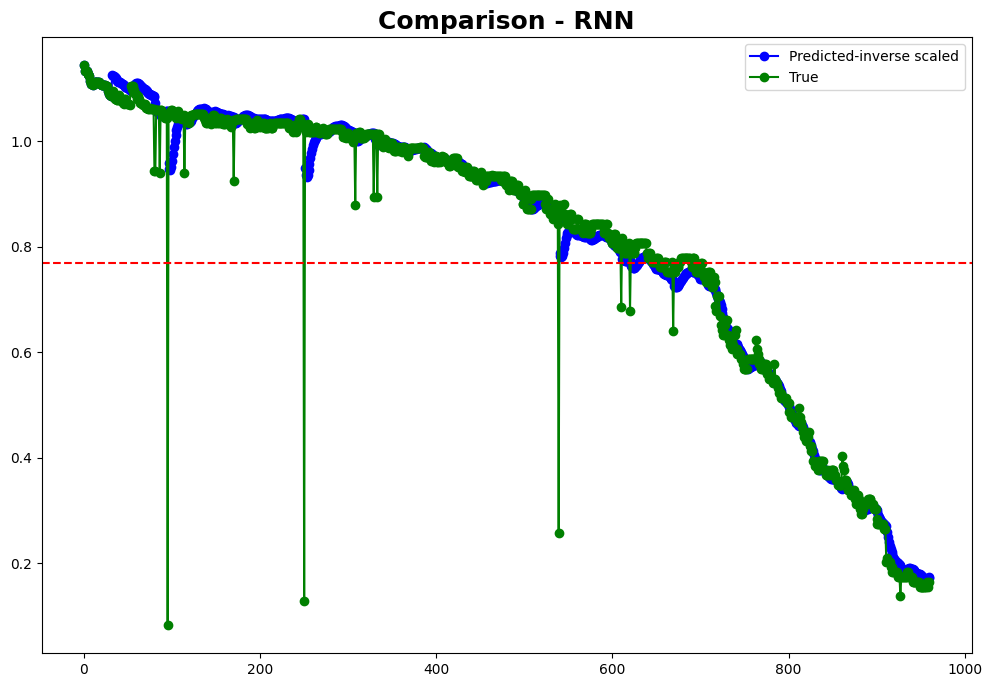

In [66]:
plt.figure(figsize = (12,8))

plt.plot(y_pred_future,linestyle='solid', marker='o', color='b', label='Predicted-inverse scaled')
plt.plot(test,linestyle='solid', marker='o', color='g', label='True')


plt.axhline(y = .7*1.1, color = 'r', linestyle = '--')




plt.title("Comparison - RNN", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [67]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_future[:-1], test, squared=False)

0.052874141745156054

In [68]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM


from numpy.random import seed
seed(42)



opt = keras.optimizers.Adam()
callback = keras.callbacks.EarlyStopping(monitor='loss',patience =3)


model = Sequential()
model.add(LSTM(64,return_sequences=False))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer=opt, loss='mae', metrics=['mse', 'mae', 'mape', keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly = True)

In [69]:
model.fit(X1_,y1, epochs=30, verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 25ms/step - loss: 0.2918 - mse: 0.1408 - mae: 0.2918 - mape: 38.7154 - rmse: 0.3752
Epoch 2/30
25/25 [==============================] - 1s 25ms/step - loss: 0.0468 - mse: 0.0034 - mae: 0.0468 - mape: 6.6278 - rmse: 0.0579
Epoch 3/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0284 - mse: 0.0013 - mae: 0.0284 - mape: 4.1741 - rmse: 0.0364
Epoch 4/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0174 - mse: 6.2441e-04 - mae: 0.0174 - mape: 2.6556 - rmse: 0.0250
Epoch 5/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0118 - mse: 3.0918e-04 - mae: 0.0118 - mape: 1.6956 - rmse: 0.0176
Epoch 6/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0106 - mse: 2.3094e-04 - mae: 0.0106 - mape: 1.4909 - rmse: 0.0152
Epoch 7/30
25/25 [==============================] - 1s 27ms/step - loss: 0.0095 - mse: 2.0860e-04 - mae: 0.0095 - mape: 1.3340 - rmse: 0.0144
Epoch 8/30
25/25 

In [70]:
model.fit(X2_,y2, epochs=30, verbose=1)

Epoch 1/30
26/26 [==============================] - 1s 26ms/step - loss: 0.0123 - mse: 3.8993e-04 - mae: 0.0123 - mape: 1433.7450 - rmse: 0.0197
Epoch 2/30
26/26 [==============================] - 1s 25ms/step - loss: 0.0118 - mse: 3.7649e-04 - mae: 0.0118 - mape: 1137.8262 - rmse: 0.0194
Epoch 3/30
26/26 [==============================] - 1s 25ms/step - loss: 0.0110 - mse: 3.6909e-04 - mae: 0.0110 - mape: 1136.6871 - rmse: 0.0192
Epoch 4/30
26/26 [==============================] - 1s 25ms/step - loss: 0.0103 - mse: 3.3708e-04 - mae: 0.0103 - mape: 1183.2522 - rmse: 0.0184
Epoch 5/30
26/26 [==============================] - 1s 25ms/step - loss: 0.0104 - mse: 3.4142e-04 - mae: 0.0104 - mape: 1185.6246 - rmse: 0.0185
Epoch 6/30
26/26 [==============================] - 1s 26ms/step - loss: 0.0104 - mse: 3.3986e-04 - mae: 0.0104 - mape: 1156.4585 - rmse: 0.0184
Epoch 7/30
26/26 [==============================] - 1s 25ms/step - loss: 0.0102 - mse: 3.2944e-04 - mae: 0.0102 - mape: 1159.2057 

In [71]:
model.fit(X3_,y3, epochs=30, verbose=1)

Epoch 1/30
28/28 [==============================] - 1s 32ms/step - loss: 0.0080 - mse: 1.4297e-04 - mae: 0.0080 - mape: 1.3020 - rmse: 0.0120
Epoch 2/30
28/28 [==============================] - 1s 28ms/step - loss: 0.0077 - mse: 1.4335e-04 - mae: 0.0077 - mape: 1.2431 - rmse: 0.0120
Epoch 3/30
28/28 [==============================] - 1s 33ms/step - loss: 0.0082 - mse: 1.4983e-04 - mae: 0.0082 - mape: 1.3103 - rmse: 0.0122
Epoch 4/30
28/28 [==============================] - 1s 28ms/step - loss: 0.0082 - mse: 1.3699e-04 - mae: 0.0082 - mape: 1.3057 - rmse: 0.0117
Epoch 5/30
28/28 [==============================] - 1s 32ms/step - loss: 0.0105 - mse: 1.9996e-04 - mae: 0.0105 - mape: 1.6101 - rmse: 0.0141
Epoch 6/30
28/28 [==============================] - 1s 36ms/step - loss: 0.0086 - mse: 1.6101e-04 - mae: 0.0086 - mape: 1.3620 - rmse: 0.0127
Epoch 7/30
28/28 [==============================] - 1s 34ms/step - loss: 0.0085 - mse: 1.4940e-04 - mae: 0.0085 - mape: 1.3353 - rmse: 0.0122
Epoch 

In [72]:
test = data_all['CS2_36']
test = test.dropna()

In [73]:
test = test['discharging capacity']
test = pd.DataFrame(test)
test = ss.fit_transform(test)

In [74]:
test_predictions_huber = []

test_predictions_huber.extend(test[:n_input])

for i in range(len(test)-n_input+1):
    
    # get the prediction value for the first batch
    
    dummy = test[i:i+n_input].reshape((1, n_input, 1))
    # use the prediction to update the batch and remove the first value
    current_batch = (dummy)
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_huber.append(current_pred) 



1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


In [75]:
test = ss.inverse_transform(test)
y_pred_future_huber = ss.inverse_transform(test_predictions_huber)

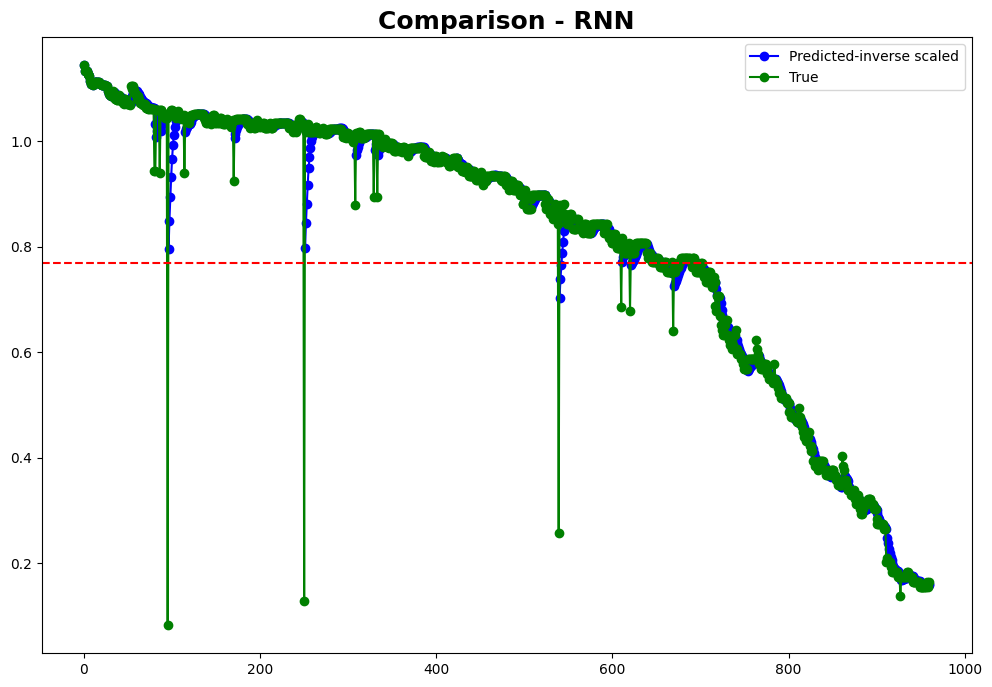

In [76]:
plt.figure(figsize = (12,8))

plt.plot(y_pred_future_huber,linestyle='solid', marker='o', color='b', label='Predicted-inverse scaled')
plt.plot(test,linestyle='solid', marker='o', color='g', label='True')


plt.axhline(y = .7*1.1, color = 'r', linestyle = '--')




plt.title("Comparison - RNN", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [77]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_future_huber[:-1], test, squared=False)

0.053218641410747836

In [78]:
mse_custom = []
for k in range(len(test)):
    mse_custom.append(mean_squared_error(y_pred_future[k],test[k]))
    
mse_huber = []
for k in range(len(test)):
    mse_huber.append(mean_squared_error(y_pred_future_huber[k],test[k]))

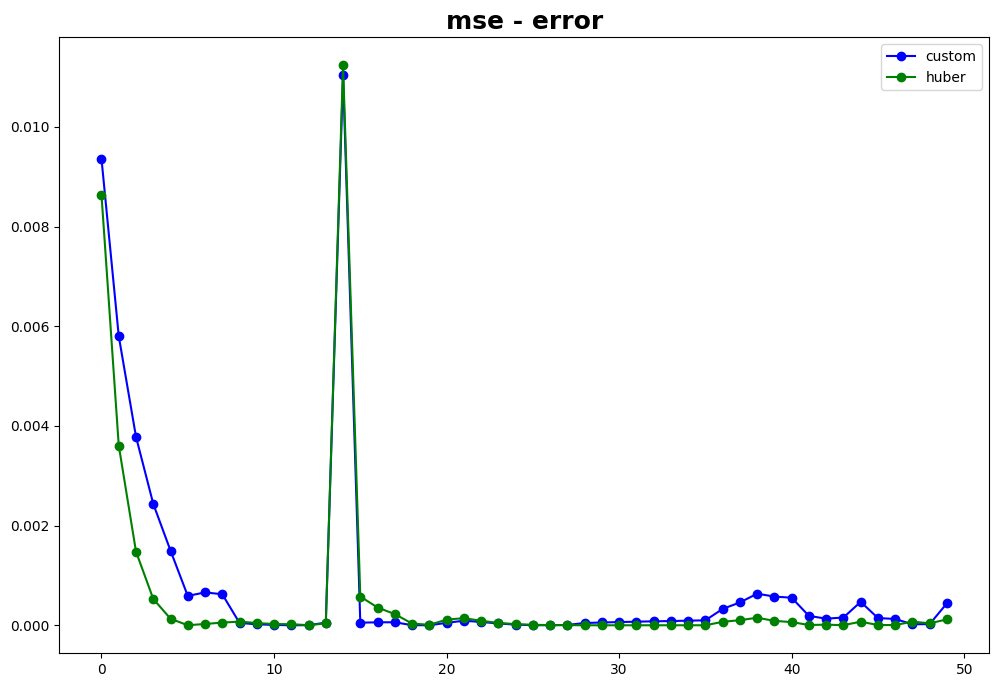

In [79]:
plt.figure(figsize = (12,8))

plt.plot(mse_custom[100:150],linestyle='solid', marker='o', color='b', label='custom')
plt.plot(mse_huber[100:150],linestyle='solid', marker='o', color='g', label='huber')



plt.title("mse - error", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

### RUL

In [80]:
from utility import drop_outlier_sw

name = battery_list[0]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t1 = battery['cycle']
y1 = battery['discharging capacity']


rolling_window = 20
idx = drop_outlier_sw(y1, rolling_window)

t1 = np.array(t1[idx])
y1 = np.array(y1[idx])



name = battery_list[2]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t2 = battery['cycle']
y2 = battery['discharging capacity']

rolling_window = 20
idx = drop_outlier_sw(y2, rolling_window)

t2 = np.array(t2[idx])
y2 = np.array(y2[idx])



name = battery_list[3]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t3 = battery['cycle']
y3 = battery['discharging capacity']

rolling_window = 20
idx = drop_outlier_sw(y3, rolling_window)

t3 = np.array(t3[idx])
y3 = np.array(y3[idx])

In [81]:
true_ttf1, idx_ttf1 = cal_ttf(t1, y1, .7*1.1)
true_ttf2, idx_ttf2 = cal_ttf(t2, y2, .7*1.1)
true_ttf3, idx_ttf3 = cal_ttf(t3, y3, .7*1.1)


In [82]:
initial_rul1 = true_ttf1 - 32
initial_rul2 = true_ttf2 - 32
initial_rul3 = true_ttf3 - 32


In [83]:
### calculate RUL on sliding window

window_size = n_input = 32

X1 = []
Y1 = []

k=0
j=0

window_cycle = initial_rul1
while window_cycle > 0:
    window_cycle = initial_rul1-k
    window = np.array(y1[j:j+window_size])
    k+=1
    j+=1
    X1.append(window)
    Y1.append(window_cycle)
    
X1 = np.array(X1)
Y1 = np.array(Y1)


##############
X2 = []
Y2 = []

k=0
j=0

window_cycle = initial_rul2
while window_cycle > 0:
    window_cycle = initial_rul2-k
    window = np.array(y2[j:j+window_size])
    k+=1
    j+=1
    X2.append(window)
    Y2.append(window_cycle)
    
X2 = np.array(X2)
Y2 = np.array(Y2)

#############

X3 = []
Y3 = []

k=0
j=0

window_cycle = initial_rul3
while window_cycle > 0:
    window_cycle = initial_rul3-k
    window = np.array(y3[j:j+window_size])
    k+=1
    j+=1
    X3.append(window)
    Y3.append(window_cycle)
    
X3 = np.array(X3)
Y3 = np.array(Y3)



In [84]:
from sklearn.preprocessing import MinMaxScaler

ss1 = MinMaxScaler()
ss2 = MinMaxScaler()
ss3 = MinMaxScaler()

Y1 = pd.DataFrame(Y1)
Y1 = ss1.fit_transform(Y1)

Y2 = pd.DataFrame(Y2)
Y2 = ss1.fit_transform(Y2)

Y3 = pd.DataFrame(Y3)
Y3 = ss1.fit_transform(Y3)

In [85]:
X1 = X1[:608]
Y1 = Y1[:608]

X1 = X1.reshape((X1.shape[0], X1.shape[1], 1))
Y1 = Y1.reshape(Y1.shape[0],1)

X2 = X2[:608]
Y2 = Y2[:608]
X2 = X2.reshape((X2.shape[0], X2.shape[1], 1))
Y2 = Y2.reshape(Y2.shape[0],1)

X3 = X3[:768]
Y3 = Y3[:768]
X3 = X3.reshape((X3.shape[0], X3.shape[1], 1))
Y3 = Y3.reshape(Y3.shape[0],1)

    val = y_pred - m
    m = y_pred
    print(m)
    print(val+ tf.math.abs(y_true-y_pred))

In [86]:
len(X3)

768

In [87]:
m = 0

def loss(y_true,y_pred):
    global m 
    val = y_pred - m
    m = y_pred
    print((val))
    print(tensorflow.executing_eagerly())
    return (val) + tensorflow.math.abs((y_true-y_pred))

In [88]:
def huber_fn(y_true, y_pred):
    global m 
    val = y_pred - m
    m = y_true
    error = y_true - y_pred
    is_small_error = tensorflow.abs(error) < 1 + val
    squared_loss = tensorflow.square(error) / 2 + tensorflow.square(val)
    linear_loss  = tensorflow.abs(error) - 0.5
    print(tensorflow.executing_eagerly())
    return tensorflow.where(is_small_error, squared_loss, linear_loss)

In [89]:
def penalty(y_true,y_pred):
    a = 15
    b = 10
    err = y_true-y_pred
    is_negative_error = err < 0
    print(err)
    print(tensorflow.executing_eagerly())
    under = tensorflow.math.exp((-err/a))-1
    over = tensorflow.math.exp((err/b))-1
    print(over)
    print(tensorflow.executing_eagerly())
    return tf.where(is_negative_error, under, over)

In [90]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM, Dropout, BatchNormalization, Bidirectional


from numpy.random import seed
seed(42)



opt = tensorflow.keras.optimizers.Adam()
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',patience =3)


model_rul = Sequential()
model_rul.add((LSTM(16,return_sequences=False)))
model_rul.add(Dense(8, activation='relu'))
model_rul.add(Dense(1, activation='relu'))

model_rul.compile(optimizer=opt, loss='mae', metrics=['mse', 'mae', 'mape', tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly = True)

In [91]:
model_rul.fit(X1,Y1, epochs=20, verbose=2)

Epoch 1/20
19/19 - 1s - loss: 0.4191 - mse: 0.2471 - mae: 0.4191 - mape: 71.5058 - rmse: 0.4971 - 835ms/epoch - 44ms/step
Epoch 2/20
19/19 - 1s - loss: 0.3109 - mse: 0.1457 - mae: 0.3109 - mape: 63.5620 - rmse: 0.3817 - 522ms/epoch - 27ms/step
Epoch 3/20
19/19 - 1s - loss: 0.2271 - mse: 0.0715 - mae: 0.2271 - mape: 94.2532 - rmse: 0.2674 - 608ms/epoch - 32ms/step
Epoch 4/20
19/19 - 0s - loss: 0.2225 - mse: 0.0655 - mae: 0.2225 - mape: 85.0432 - rmse: 0.2560 - 474ms/epoch - 25ms/step
Epoch 5/20
19/19 - 0s - loss: 0.2194 - mse: 0.0630 - mae: 0.2194 - mape: 87.8189 - rmse: 0.2509 - 451ms/epoch - 24ms/step
Epoch 6/20
19/19 - 0s - loss: 0.2154 - mse: 0.0607 - mae: 0.2154 - mape: 84.8315 - rmse: 0.2463 - 473ms/epoch - 25ms/step
Epoch 7/20
19/19 - 1s - loss: 0.2097 - mse: 0.0576 - mae: 0.2097 - mape: 84.4458 - rmse: 0.2399 - 501ms/epoch - 26ms/step
Epoch 8/20
19/19 - 0s - loss: 0.1987 - mse: 0.0511 - mae: 0.1987 - mape: 80.4778 - rmse: 0.2261 - 480ms/epoch - 25ms/step
Epoch 9/20
19/19 - 0s - 

In [92]:
model_rul.fit(X2,Y2, epochs=20, verbose=2)

Epoch 1/20
19/19 - 0s - loss: 0.0500 - mse: 0.0038 - mae: 0.0500 - mape: 10.5657 - rmse: 0.0613 - 498ms/epoch - 26ms/step
Epoch 2/20
19/19 - 0s - loss: 0.0360 - mse: 0.0022 - mae: 0.0360 - mape: 7.0498 - rmse: 0.0467 - 463ms/epoch - 24ms/step
Epoch 3/20
19/19 - 0s - loss: 0.0324 - mse: 0.0018 - mae: 0.0324 - mape: 5.9043 - rmse: 0.0427 - 469ms/epoch - 25ms/step
Epoch 4/20
19/19 - 0s - loss: 0.0291 - mse: 0.0016 - mae: 0.0291 - mape: 5.0588 - rmse: 0.0397 - 475ms/epoch - 25ms/step
Epoch 5/20
19/19 - 0s - loss: 0.0306 - mse: 0.0017 - mae: 0.0306 - mape: 5.4053 - rmse: 0.0414 - 466ms/epoch - 25ms/step
Epoch 6/20
19/19 - 0s - loss: 0.0295 - mse: 0.0016 - mae: 0.0295 - mape: 5.0301 - rmse: 0.0406 - 479ms/epoch - 25ms/step
Epoch 7/20
19/19 - 0s - loss: 0.0328 - mse: 0.0020 - mae: 0.0328 - mape: 5.7357 - rmse: 0.0451 - 475ms/epoch - 25ms/step
Epoch 8/20
19/19 - 0s - loss: 0.0314 - mse: 0.0018 - mae: 0.0314 - mape: 5.5797 - rmse: 0.0424 - 485ms/epoch - 26ms/step
Epoch 9/20
19/19 - 0s - loss: 0

In [93]:
model_rul.fit(X3,Y3, epochs=20, verbose=2)

Epoch 1/20
24/24 - 1s - loss: 0.0303 - mse: 0.0014 - mae: 0.0303 - mape: 16.6644 - rmse: 0.0375 - 641ms/epoch - 27ms/step
Epoch 2/20
24/24 - 1s - loss: 0.0349 - mse: 0.0021 - mae: 0.0349 - mape: 12.3034 - rmse: 0.0460 - 594ms/epoch - 25ms/step
Epoch 3/20
24/24 - 1s - loss: 0.0298 - mse: 0.0015 - mae: 0.0298 - mape: 10.8059 - rmse: 0.0388 - 585ms/epoch - 24ms/step
Epoch 4/20
24/24 - 1s - loss: 0.0273 - mse: 0.0013 - mae: 0.0273 - mape: 10.9888 - rmse: 0.0358 - 589ms/epoch - 25ms/step
Epoch 5/20
24/24 - 1s - loss: 0.0265 - mse: 0.0012 - mae: 0.0265 - mape: 10.3497 - rmse: 0.0342 - 581ms/epoch - 24ms/step
Epoch 6/20
24/24 - 1s - loss: 0.0228 - mse: 8.7166e-04 - mae: 0.0228 - mape: 9.4503 - rmse: 0.0295 - 584ms/epoch - 24ms/step
Epoch 7/20
24/24 - 1s - loss: 0.0226 - mse: 9.2210e-04 - mae: 0.0226 - mape: 9.4795 - rmse: 0.0304 - 586ms/epoch - 24ms/step
Epoch 8/20
24/24 - 1s - loss: 0.0238 - mse: 9.7633e-04 - mae: 0.0238 - mape: 9.9459 - rmse: 0.0312 - 590ms/epoch - 25ms/step
Epoch 9/20
24/2

In [94]:
y_pred_future = np.array(y_pred_future)
test = np.array(test)

In [95]:
cycle = np.arange(1,len(y_pred_future))

In [96]:
true_test, idx_test = cal_ttf(cycle, y_pred_future,  .7*1.1)

In [97]:
true_test

624

In [98]:

rul_test = true_test - 32
rul_test

y_test = []
k=0

window_cycle = rul_test
while window_cycle > 0:
    window_cycle = rul_test-k
    y_test.append(window_cycle)
    k+=1
    
y_test = np.array(y_test)


In [99]:
rul_predictions = []

k=0
j=0

first_eval_batch = y_pred_future[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(y_pred_future[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


In [100]:
rul_pred = ss1.inverse_transform(rul_predictions)

In [101]:
rul_predictions

[array([1.0331033], dtype=float32),
 array([1.0331379], dtype=float32),
 array([1.0324595], dtype=float32),
 array([1.0317768], dtype=float32),
 array([1.0311434], dtype=float32),
 array([1.0306523], dtype=float32),
 array([1.0302092], dtype=float32),
 array([1.0298833], dtype=float32),
 array([1.029785], dtype=float32),
 array([1.0298198], dtype=float32),
 array([1.0298398], dtype=float32),
 array([1.0297772], dtype=float32),
 array([1.0295497], dtype=float32),
 array([1.0291549], dtype=float32),
 array([1.028702], dtype=float32),
 array([1.0282148], dtype=float32),
 array([1.0277604], dtype=float32),
 array([1.0273472], dtype=float32),
 array([1.0269418], dtype=float32),
 array([1.026627], dtype=float32),
 array([1.0263143], dtype=float32),
 array([1.0260092], dtype=float32),
 array([1.0257196], dtype=float32),
 array([1.0256609], dtype=float32),
 array([1.0257639], dtype=float32),
 array([1.0260906], dtype=float32),
 array([1.0266395], dtype=float32),
 array([1.0273587], dtype=float

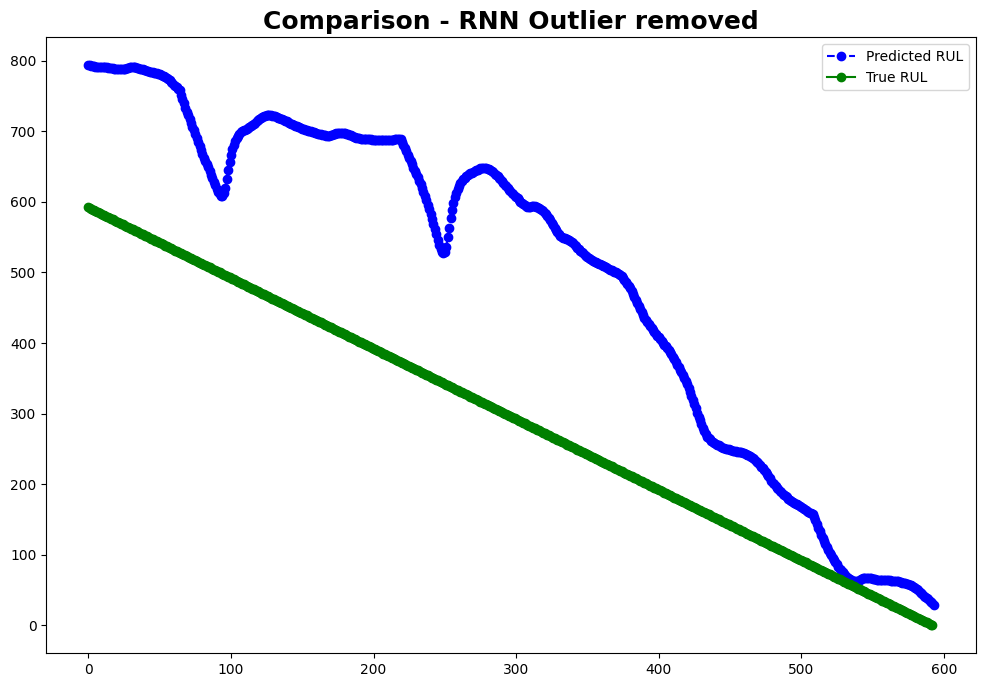

In [102]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [103]:
y_pred_future_huber = np.array(y_pred_future_huber)
test = np.array(test)
cycle = np.arange(1,len(y_pred_future_huber))
true_test, idx_test = cal_ttf(cycle, y_pred_future_huber,  .7*1.1)

In [104]:
true_test

543

In [105]:
rul_predictions_custom = []

k=0
j=0

first_eval_batch = y_pred_future_huber[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(y_pred_future_huber[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions_custom.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


In [106]:
rul_pred_custom = ss1.inverse_transform(rul_predictions_custom)

In [107]:
rul_predictions_custom

[array([1.0331033], dtype=float32),
 array([1.0313228], dtype=float32),
 array([1.0296869], dtype=float32),
 array([1.0281198], dtype=float32),
 array([1.0265331], dtype=float32),
 array([1.0250329], dtype=float32),
 array([1.0235778], dtype=float32),
 array([1.0222467], dtype=float32),
 array([1.0211664], dtype=float32),
 array([1.0203089], dtype=float32),
 array([1.019464], dtype=float32),
 array([1.0184613], dtype=float32),
 array([1.0172524], dtype=float32),
 array([1.0158343], dtype=float32),
 array([1.0142821], dtype=float32),
 array([1.0126421], dtype=float32),
 array([1.0110636], dtype=float32),
 array([1.0095042], dtype=float32),
 array([1.0078334], dtype=float32),
 array([1.0061908], dtype=float32),
 array([1.0044736], dtype=float32),
 array([1.0026865], dtype=float32),
 array([1.0008355], dtype=float32),
 array([0.9994876], dtype=float32),
 array([0.99828494], dtype=float32),
 array([0.9973668], dtype=float32),
 array([0.99670357], dtype=float32),
 array([0.9961898], dtype=f

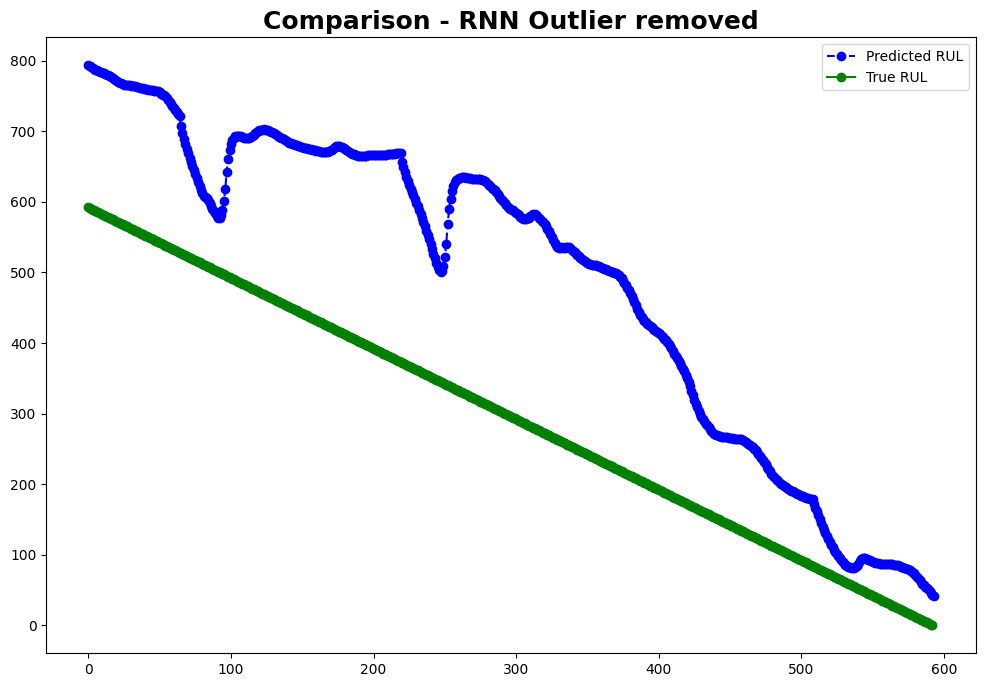

In [108]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred_custom,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [109]:
rul_predictions_test = []

k=0
j=0

first_eval_batch = test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(test[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions_test.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


In [110]:
rul_predictions_test = ss1.inverse_transform(rul_predictions_test)

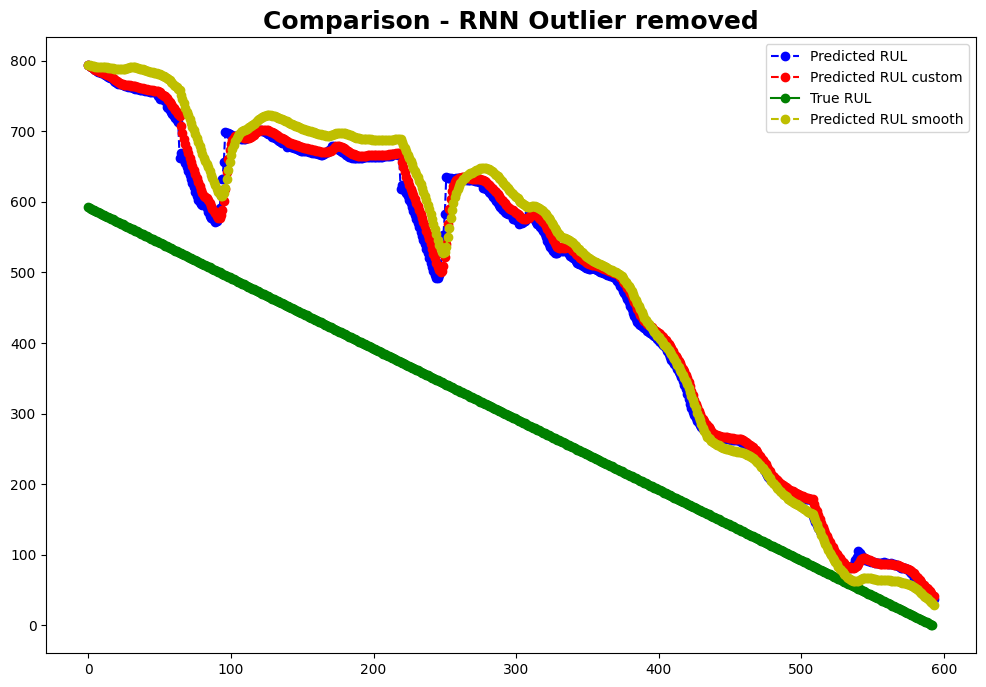

In [111]:
plt.figure(figsize = (12,8))

plt.plot(rul_predictions_test,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Predicted RUL custom')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.plot(rul_pred,linestyle='--', marker='o', color='y', label='Predicted RUL smooth')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [112]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, rul_predictions_test[:-1], squared=False)


204.70945593404164

In [113]:
### NEURAL FILTERED

mean_squared_error(y_test, rul_pred[:-1], squared=False)

222.74185410507476

In [114]:
### NEURAL FILTERED custom loss


%load_ext jupyternotify


<IPython.core.display.Javascript object>

In [115]:
%%notify

mean_squared_error(y_test, rul_pred_custom[:-1], squared=False)

210.29649382173076

<IPython.core.display.Javascript object>

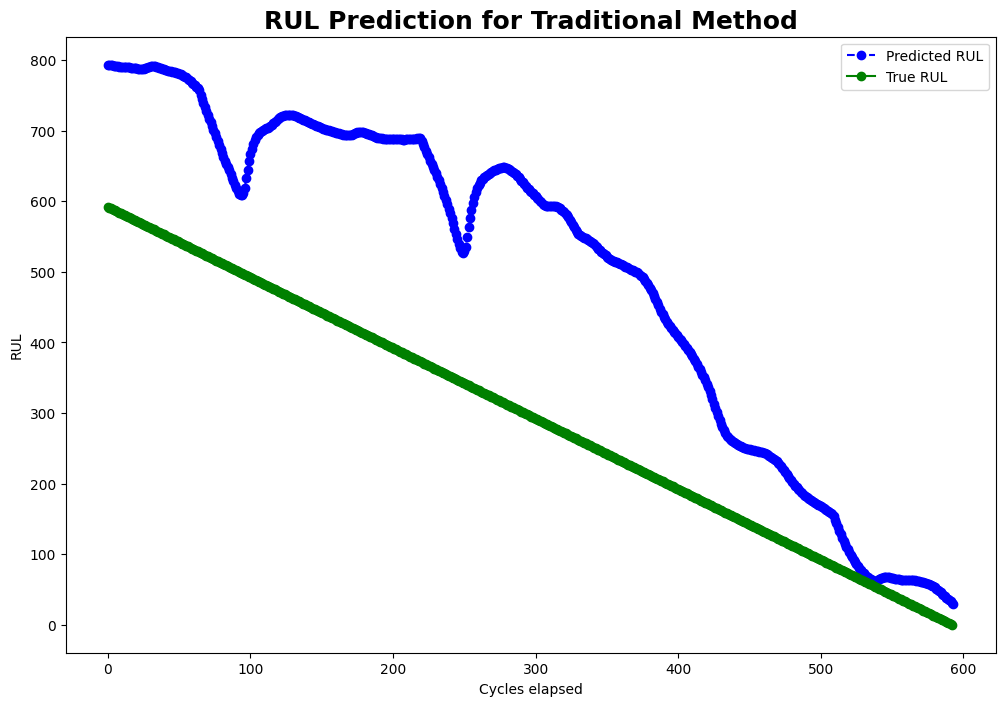

In [116]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')

plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.title("RUL Prediction for Traditional Method", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

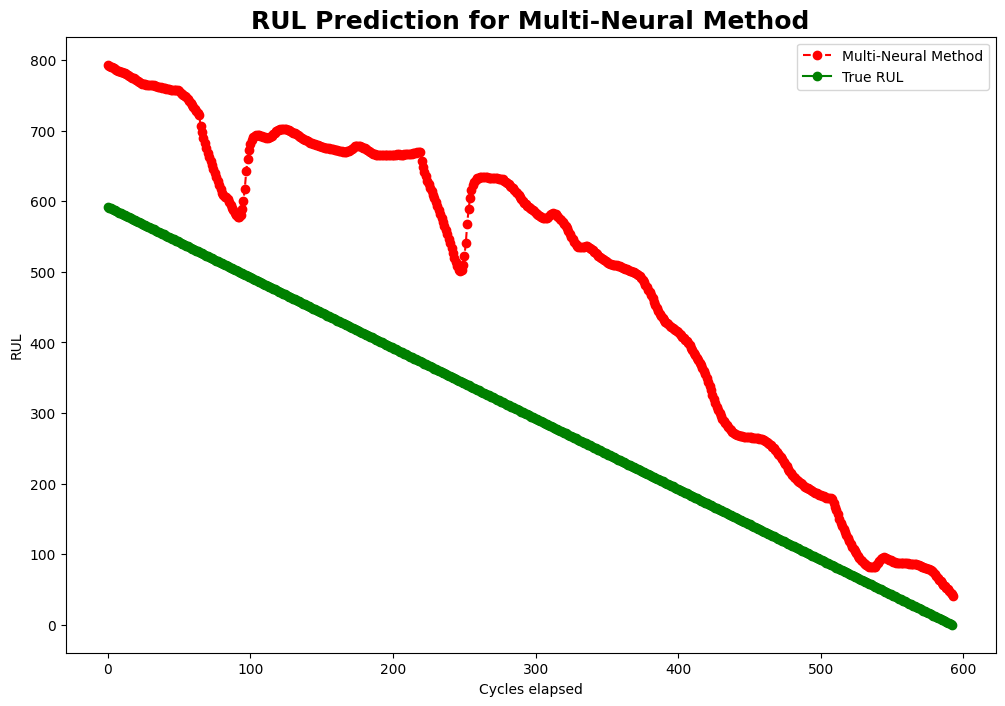

In [117]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Multi-Neural Method')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.title("RUL Prediction for Multi-Neural Method", fontsize=18, fontweight="bold")
plt.legend()


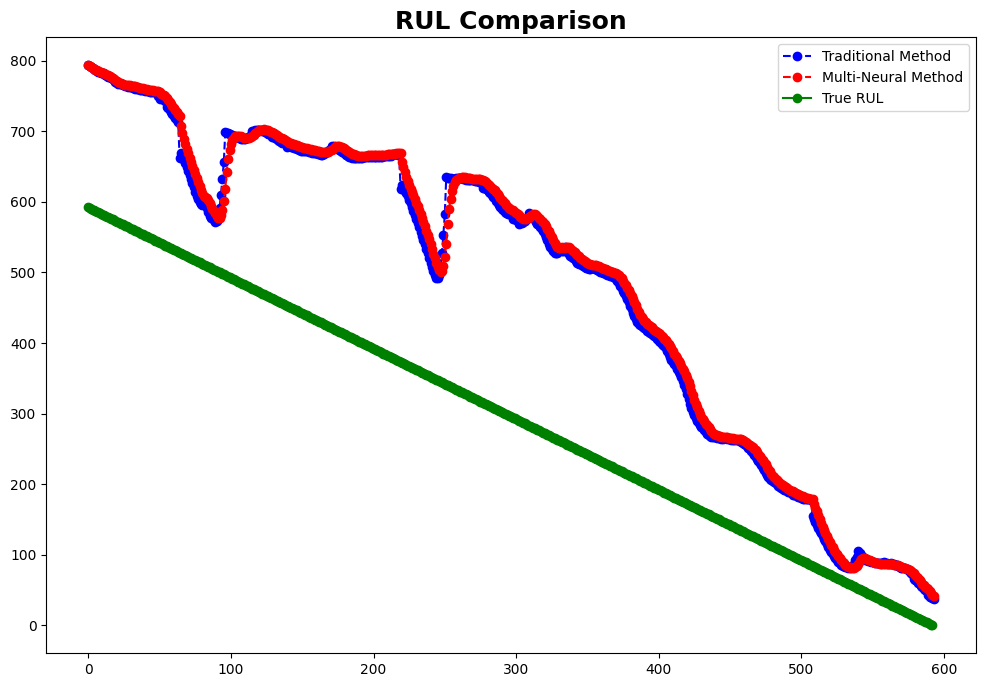

In [118]:
plt.figure(figsize = (12,8))

plt.plot(rul_predictions_test,linestyle='--', marker='o', color='b', label='Traditional Method')
plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Multi-Neural Method')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.title("RUL Comparison", fontsize=18, fontweight="bold")
plt.legend()
